May want to consider scvelo for improved assumptions in the future: https://scvelo.readthedocs.io/getting_started.html
scv also has a function to compute the pseudotime

# **Analysis**

In [1]:
import velocyto as vcy
import scvelo as scv
import numpy as np
import pandas as pd
import scipy as sc
import h5py
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tqdm import tqdm

import sys
sys.path.insert(1, '../scripts/') # comment out in python script
from load_environmental_variables import *

In [2]:
# emulating original velocyto code 
adata = scv.read(local_data_path + 'interim/velocyto/5k_pbmc_v3_count_celltypes.loom', cache=True)


# filtering out cells with low unspliced counts<--couldn't figure out how to do as in velocyto

# we want to be very lenient with gene filtering so that there are many membrane/EC proteins remaining for 
# CCI scoring, go with atleast 0.1 and 0.01% of respective dimension for now
# this cuts it down from 33k genes to 11k genes
scv.pp.filter_and_normalize(adata, 
                            min_counts = round(0.001*adata.layers['spliced'].shape[1]), min_counts_u = None, 
                            min_cells = round(0.01*adata.layers['spliced'].shape[0]),
                            min_cells_u = None,#round(np.percentile(adata.layers['unspliced'].sum(axis = 1), 0.5)),
                            n_top_genes = None
                           )


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 22652 genes that are detected 34 counts (spliced).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


moments uses PCA, in future will want to figure out the numer of pcs to use

In [3]:
# when drawing information from neighbors, use 1% of all cells
n_neighbors_ = round(adata.layers['spliced'].shape[0]*0.01)
scv.pp.moments(adata, n_neighbors = n_neighbors_)

computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [4]:
scv.tl.velocity(adata, mode = 'stochastic', filter_genes = False)

computing velocities
    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


# Get Convergence Rule for Projection

In [5]:
progress = pd.DataFrame(columns = ['distance_ratio', 'delta_t_ratio', 'distance', 'delta_t'])

max_dt = 0.0001
change_0 = scv.utils.get_extrapolated_state(adata, dt = max_dt)
distance_0 = 0
progress.loc[0,:] = [float('nan'), float('nan'), float('nan'), max_dt]

t_0 = max_dt
max_dt *= 10
projected_matrix = scv.utils.get_extrapolated_state(adata, dt = max_dt)
distance_1 = np.linalg.norm(change_0-projected_matrix)
change0 = projected_matrix
progress.loc[1,:] = [float('nan'), max_dt/t_0, distance_1, max_dt]

counter = 2
while abs(distance_1/distance_0 - max_dt/t_0) >= 0.00001:
    t_0 = max_dt
    max_dt += 1
        
    projected_matrix = scv.utils.get_extrapolated_state(adata, dt = max_dt)
    distance_0 = distance_1
    distance_1 = np.linalg.norm(change_0-projected_matrix)
    progress.loc[counter,:] = [distance_1/distance_0, max_dt/t_0, distance_1, max_dt]
    change0 = projected_matrix
    counter += 1

max_dt = round(max_dt)
# generate 100 time points between 0 and max_dt
time_points = np.arange(0, max_dt + max_dt/100, max_dt/99)

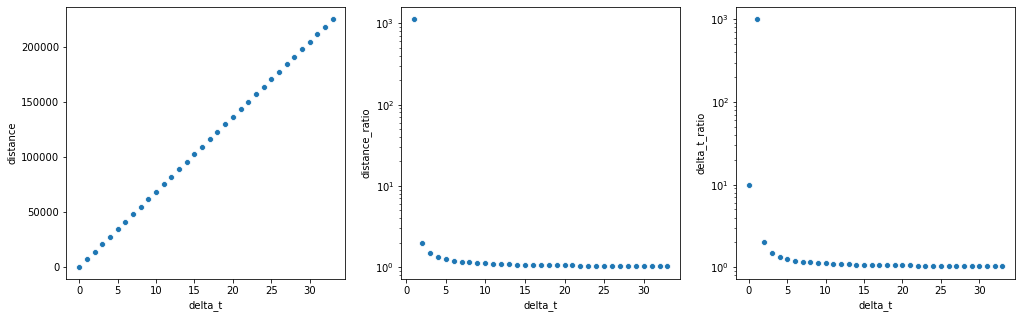

In [6]:
fig, ax = plt.subplots(ncols=3, figsize = (17,5))
g0 = sns.scatterplot(x = 'delta_t', y ='distance', data = progress, ax = ax[0])

g1 = sns.scatterplot(x = 'delta_t', y ='distance_ratio', data = progress, ax = ax[1])
ax[1].set_yscale('log')

g2 = sns.scatterplot(x = 'delta_t', y ='delta_t_ratio', data = progress, ax = ax[2])
ax[2].set_yscale('log')

plt.savefig(local_data_path + 'figures/dt_convergence.pdf', bbox_inches='tight')
plt.savefig(local_data_path + 'figures/dt_convergence.png', bbox_inches='tight')

# Project Expression Matrix and Save results

In [7]:
if not os.path.isdir(local_data_path + 'interim/velocyto_analyses/'):
    os.mkdir(local_data_path + 'interim/velocyto_analyses/')

In [8]:
# assume vlm.Sx_sz is at t = 0, create h5 object
# h5py will create a compressed object containing all the matrices, which can be used to transfer data to others
expression_dt = h5py.File(local_data_path + 'interim/velocyto_analyses/expression_dt.h5', 'w')
expression_dt.create_dataset(str(0), data = adata.layers['Ms']) # expression_over_time = {0: vlm.Sx_sz}

for dt_ in tqdm(time_points[1:]):
    expression_dt.create_dataset(str(dt_), 
                                 data=scv.utils.get_extrapolated_state(adata, dt = dt_)) # do the projection

expression_dt.close()

# write file with cell names
with open(local_data_path + 'interim/velocyto_analyses/column_names.txt', 'w') as f:
    for name in adata.obs.index.tolist():
        f.write(name + '\n')


# repeat for rownames
with open(local_data_path + 'interim/velocyto_analyses/row_names.txt', 'w') as f:
    for name in adata.var.index.tolist():
        f.write(name + '\n')

100%|██████████| 99/99 [04:30<00:00,  2.73s/it]


In [37]:
cell_ids = open(local_data_path + 'interim/velocyto_analyses/column_names.txt').read().splitlines()
gene_names = open(local_data_path + 'interim/velocyto_analyses/row_names.txt').read().splitlines()

expression_dt = h5py.File(local_data_path + 'interim/velocyto_analyses/expression_dt.h5', "r")
if not os.path.isdir(local_data_path + 'interim/velocyto_analyses/projected_gene_expression_csvs/'):
    os.mkdir(local_data_path + 'interim/velocyto_analyses/projected_gene_expression_csvs/')
    
for dt in tqdm(expression_dt.keys()):
    expression_df = pd.DataFrame(np.array(expression_dt[dt]).T, columns = cell_ids, index = gene_names)
    fn = local_data_path + 'interim/velocyto_analyses/projected_gene_expression_csvs/'
    fn += 'T-' + '{:04f}'.format(float(dt))  + '-Expression.csv'
    expression_df.to_csv(fn)

# Get Cell Ordering

In [38]:
# get transition matrix
scv.tl.velocity_graph(adata)
# get ordering of cells
scv.tl.velocity_pseudotime(adata)
adata.obs.to_csv(local_data_path + 'interim/velocyto_analyses/velocyto_attributes.csv')

computing velocity graph
    finished (0:01:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 3 regions of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


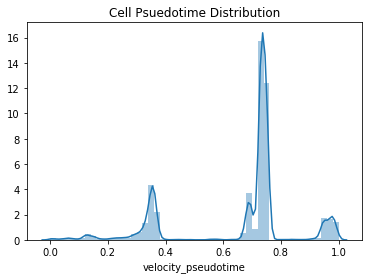

In [39]:
fig, ax = plt.subplots()
sns.distplot(adata.obs.velocity_pseudotime, ax = ax)
ax.set_title('Cell Psuedotime Distribution')
plt.savefig(local_data_path + 'figures/cell_psuedotime_distribution.pdf', bbox_to_inches = 'tight')
plt.savefig(local_data_path + 'figures/cell_psuedotime_distribution.png', bbox_to_inches = 'tight');

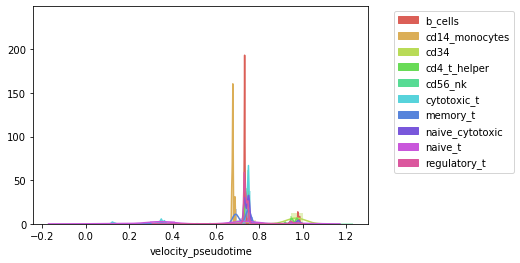

In [89]:
fig, ax = plt.subplots()

counter = 0
uct = sorted(adata.obs.Cell_Type.unique())
colors = sns.color_palette("hls", len(uct))
for ct in uct:
    viz_df = adata.obs[adata.obs.Cell_Type == ct]
    sns.distplot(viz_df.velocity_pseudotime, color = colors[counter], kde = 1,norm_hist = 1, 
                 ax = ax)
    counter += 1
ax.legend(handles = [mpatches.Patch(color=colors[i], label=uct[i]) for i in range(len(uct))], 
         bbox_to_anchor = (1.45,1))
plt.savefig(local_data_path + 'figures/cell_psuedotime_distribution_bycelltype.pdf', bbox_to_inches = 'tight')
plt.savefig(local_data_path + 'figures/cell_psuedotime_distribution_bycelltype.png', bbox_to_inches = 'tight');